# Modellieren und Auswerten

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from mtpl.data_util import load_freq_df, load_sev_df, print_data_summary
from mtpl.eval_util import get_metrics, plot_quantiles
random_state = np.random.RandomState(20241119)

## Preprocessing

Wir laden die Daten, führen beide Datensätze zusammen und berechnen die Zielvariable.

In [2]:
freq_df = load_freq_df()
sev_df = load_sev_df()

In [3]:
categorical_features = ["Area", "VehBrand", "VehGas", "Region"]
numerical_features = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
features = [*categorical_features, *numerical_features]

claims_by_pol = sev_df.groupby("IDpol").agg(
    claim_count=pd.NamedAgg(column="IDpol", aggfunc="count"),
    claim_amount=pd.NamedAgg(column="ClaimAmount", aggfunc="sum"),
)
merge_df = freq_df.merge(claims_by_pol, how="left", left_on="IDpol", right_index=True)
merge_df["claim_count"] = merge_df["claim_count"].fillna(0)
merge_df["claim_amount"] = merge_df["claim_amount"].fillna(0.0)

df = merge_df[merge_df["ClaimNb"] == merge_df["claim_count"]].copy()
df[numerical_features] = df[numerical_features].clip(upper=df[numerical_features].quantile(0.95), axis=1)
df["claims_per_year"] = (df["claim_count"] / df["Exposure"])
df["claim_amount_per_year"] = (df["claim_amount"] / df["Exposure"])
print_data_summary(df, "claims_per_year")

Daten 668896, positive Zielvariable: 24943 (3.73%)


Wir teilen die Daten in Trainings- und Testdatensatz auf. In beiden Datensätzen wollen wir den gleichen Anteil an positiven Zielvariablen.

In [4]:
stratify_by = (df["claim_amount_per_year"] > 0).astype(int)
train_plus_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state, stratify=stratify_by)
n_test = test_df.shape[0]
print_data_summary(train_plus_df, "claim_amount_per_year")
print_data_summary(test_df, "claim_amount_per_year")

Daten 535116, positive Zielvariable: 19954 (3.73%)
Daten 133780, positive Zielvariable: 4989 (3.73%)


Im Trainingsdatensatz erstellen wir gestutzte Versionen der Zielvariable um den Einfluss von Ausreißern zu verringern.

In [5]:
train_plus_df["claims_per_year_clipped"] = train_plus_df["claims_per_year"].clip(upper=5)
train_plus_df["claim_amount_per_year_clipped"] = train_plus_df["claim_amount_per_year"].clip(upper=1e4)

## Metriken und Evaluierung
Für jeden Vertrag soll die zu erwartende Schadenshöhe pro Jahr vorhergesagt werden. Dies ist ein Regressionsproblem. Das Modell werden wir mit dem quadratischen Fehler (rmse) als Zielfunktion trainieren. Für die finale Auswertung des Modells oder den Vergleich verschiedener Modelle eignet sich die quadratische Fehlerfunktion weniger, da sie von Ausreißern dominiert wird. Der absolute Fehler (mae) liegt nahe, da dieser den Geldbetrag angibt um den die Vorhersage daneben liegt und somit eng mit der Business Metric verbunden ist. Alleine nach absolutem Fehler zu optimieren ist ungünstig, da ~96% aller Werte der Zielvariable 0 sind und der absolute Fehler nach Modus (häufigster Wert) optimiert. Somit ist es schwer einen geringen absoluten Fehler zu erhalten als die konstante Vorhersage, dass der Schaden immer 0 ist. Dies liegt auch am starken Noise in der Zielvariablen. Für uns ist auch die Verzerrung (bias) interessant: Wenn wir für 1000 Verträge den Schaden vorhersagen, sollte der vorhergesagte Schaden im Durchschnitt gleich groß wie der wirkliche Schaden sein. Außerdem betrachten wir die Zielvariable als binäres Signal (Schaden ist positiv) und berechnen den Average Precision Score um zu schauen ob unser Modell die Verträge sinnvoll nach Schadenswahrscheinlichkeit sortiert.

Zunächst berechnen wir die Metriken auf den konstanten Vorhersagen Durchschnitt und 0. Dadurch kriegen wir ein Gefühl für die Größenscala der Metriken und können zukünftige Vorhersagen damit vergleichen.

In [6]:
global_mean = np.average(train_plus_df["claim_amount_per_year"], weights=train_plus_df["Exposure"])
print(f"Durchschnitt: {global_mean:.2f}")
global_mean_metrics = get_metrics(test_df["claim_amount_per_year"], np.ones(n_test) * global_mean, weights=test_df["Exposure"])
print(global_mean_metrics)
print("Konstant 0")
constant_zero_metrics = get_metrics(test_df["claim_amount_per_year"], np.zeros(n_test), weights=test_df["Exposure"])
print(constant_zero_metrics)
evaluations = [
    {"model_name": "global_mean", **global_mean_metrics},
    {"model_name": "constant_zero", **constant_zero_metrics},
]

Durchschnitt: 173.24
{'rmse': 6723.865835865735, 'mae': 310.45055684338513, 'bias': -19.783509645888252, 'aps': 0.04892442385358757}
Konstant 0
{'rmse': 6725.587737119626, 'mae': 153.46015191364987, 'bias': 153.46015191364987, 'aps': 0.04892442385358757}


## Modell trainieren
Zunächst unterteilen wir den Trainingsdatensatz nochmal in ein Trainings- und Evaluierungsdatensatz.

In [7]:
train_stratify_by = (train_plus_df["claim_amount_per_year"] > 0).astype(int)
train_df, valid_df = train_test_split(train_plus_df, test_size=0.2, random_state=random_state, stratify=train_stratify_by)
print_data_summary(train_df, target_col="claim_amount_per_year")
print_data_summary(valid_df, target_col="claim_amount_per_year")

Daten 428092, positive Zielvariable: 15963 (3.73%)
Daten 107024, positive Zielvariable: 3991 (3.73%)


### CatBoost Regressionsmodell
Wir testen CatBoost als Regressionsmodell. CatBoost als Gradient Boosting Algorithmus basierend auf Decision Trees kann sehr gut mit heterogenen (Mix aus kategorischen und numerischen) Features umgehen, hat ein starkes eingebautes Encoding für kategorische Features und performt sehr gut mit den Default-Einstellungen.

In [8]:
train_pool = Pool(
    train_df[features],
    train_df["claim_amount_per_year_clipped"],
    cat_features=categorical_features,
    weight=train_df["Exposure"],
)
eval_pool = Pool(
    valid_df[features],
    valid_df["claim_amount_per_year_clipped"],
    cat_features=categorical_features,
    weight=valid_df["Exposure"],
)
model = CatBoostRegressor(iterations=200, loss_function="RMSE")
model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=50, verbose=20)

Learning rate set to 0.3519
0:	learn: 629.7906837	test: 630.5895006	best: 630.5895006 (0)	total: 169ms	remaining: 33.6s
20:	learn: 626.8395527	test: 628.2352142	best: 628.2297690 (17)	total: 1.47s	remaining: 12.6s
40:	learn: 626.1031080	test: 628.1968161	best: 628.1568549 (26)	total: 2.54s	remaining: 9.84s
60:	learn: 624.6847300	test: 628.3102900	best: 628.1568549 (26)	total: 3.67s	remaining: 8.38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 628.1568549
bestIteration = 26

Shrink model to first 27 iterations.


In [9]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,BonusMalus,54.573566
1,DrivAge,15.169727
2,VehAge,10.493929
3,VehBrand,5.547246
4,VehPower,4.218756
5,Density,3.756314
6,Region,2.847541
7,VehGas,1.865274
8,Area,1.527647


In [10]:
pd.Series(model.predict(test_df[features])).describe()

count    133780.000000
mean        102.401862
std          73.357045
min         -42.027481
25%          60.549956
50%          78.938120
75%         114.591422
max         818.325917
dtype: float64

Das Regressionsmodell sagt auch negative Werte vorher, das ist nicht optimal. Wir erzwingen, dass die Vorhersagen mindestens 0 sind und kalibrieren um ein möglichst unverzehrtes Ergebnis zu erhalten.

In [11]:
train_predictions = np.clip(model.predict(train_plus_df[features]), 0, None)
calibration_factor = (
    np.average(train_plus_df["claim_amount_per_year"], weights=train_plus_df["Exposure"])
    / np.average(train_predictions, weights=train_plus_df["Exposure"])
)
print(calibration_factor)
test_predictions = np.clip(model.predict(test_df[features]), 0, None) * calibration_factor
regression_metrics = get_metrics(test_df["claim_amount_per_year"], test_predictions, weights=test_df["Exposure"])
print(regression_metrics)
evaluations.append({"model_name": "regression_model", **regression_metrics})

1.8342974174916855
{'rmse': 6722.952221912382, 'mae': 303.97603514530084, 'bias': -20.371276312982395, 'aps': 0.09606425532535157}


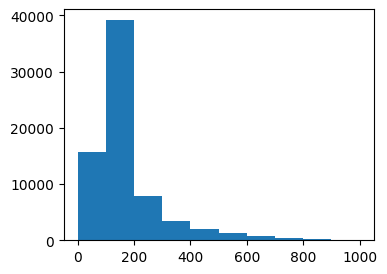

In [12]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(np.clip(test_predictions, None, 1000), weights=test_df["Exposure"]);

Das Ziel des Modells ist es, das wir Kunden je nach zu erwartender Schadenshöhe einen individuellen Preis anbieten können. Deshalb unterteilen wir die Testdaten in 10 gleiche Teile (nach Gewicht) und vergleichen den durchschnittlichen Schaden mit der durchschnittlichen Vorhersage.

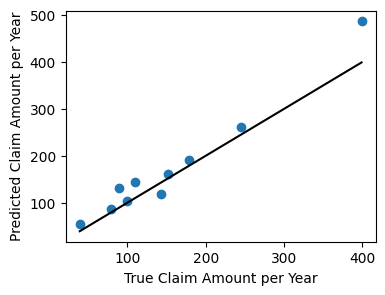

In [13]:
plot_quantiles(test_df["claim_amount_per_year"], test_predictions, weights=test_df["Exposure"], figsize=(4,3));

### CatBoost Frequenzmodell
Da das Regressionsmodell auch negative Werte ausgibt testen wir noch eine andere Variante. Wir sagen für jeden Vertrag die zu erwartende Anzahl der Schadensfälle pro Jahr voraus. Für jeden Schadensfall nehmen wir erstmal einen konstanten Betrag an und können die Schadenshöhe pro Jahr bestimmen.

In [14]:
freq_train_pool = Pool(
    train_df[features],
    train_df["claims_per_year_clipped"],
    cat_features=categorical_features,
    weight=train_df["Exposure"],
)
freq_eval_pool = Pool(
    valid_df[features],
    valid_df["claims_per_year_clipped"],
    cat_features=categorical_features,
    weight=valid_df["Exposure"],
)
freq_model = CatBoostRegressor(iterations=200, loss_function="Poisson")
freq_model.fit(freq_train_pool, eval_set=freq_eval_pool, early_stopping_rounds=50, verbose=20)

0:	learn: 0.9265047	test: 0.9265479	best: 0.9265479 (0)	total: 130ms	remaining: 25.9s
20:	learn: 0.3670234	test: 0.3675219	best: 0.3675219 (20)	total: 2.23s	remaining: 19s
40:	learn: 0.2762650	test: 0.2770693	best: 0.2770693 (40)	total: 4.14s	remaining: 16.1s
60:	learn: 0.2555480	test: 0.2565098	best: 0.2565098 (60)	total: 5.92s	remaining: 13.5s
80:	learn: 0.2497772	test: 0.2508491	best: 0.2508491 (80)	total: 8.08s	remaining: 11.9s
100:	learn: 0.2474012	test: 0.2486191	best: 0.2486191 (100)	total: 10s	remaining: 9.84s
120:	learn: 0.2463720	test: 0.2477285	best: 0.2477285 (120)	total: 12.1s	remaining: 7.92s
140:	learn: 0.2457087	test: 0.2471366	best: 0.2471366 (140)	total: 14.2s	remaining: 5.94s
160:	learn: 0.2453333	test: 0.2468625	best: 0.2468625 (160)	total: 16.3s	remaining: 3.96s
180:	learn: 0.2450451	test: 0.2466440	best: 0.2466440 (180)	total: 18.3s	remaining: 1.92s
199:	learn: 0.2447989	test: 0.2464703	best: 0.2464703 (199)	total: 20.2s	remaining: 0us

bestTest = 0.2464702827
bes

In [15]:
freq_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,BonusMalus,53.935641
1,DrivAge,14.450980
2,VehAge,8.511367
3,Density,8.279540
4,Region,4.050313
5,VehGas,3.703958
6,VehBrand,3.186016
7,VehPower,3.116420
8,Area,0.765764


In [16]:
pd.Series(freq_model.predict(test_df[features])).describe()

count    133780.000000
mean          0.076272
std           0.046110
min           0.016530
25%           0.049199
50%           0.060075
75%           0.086438
max           0.636209
dtype: float64

In [17]:
amount_per_claim = (
    np.average(train_plus_df["claim_amount_per_year"], weights=train_plus_df["Exposure"])
    / np.average(freq_model.predict(train_plus_df[features]), weights=train_plus_df["Exposure"])
)
print(amount_per_claim)
freq_predictions = freq_model.predict(test_df[features]) * amount_per_claim

2439.617255585261


In [18]:
freq_metrics = get_metrics(test_df["claim_amount_per_year"], freq_predictions, weights=test_df["Exposure"])
print(freq_metrics)
evaluations.append({"model_name": "freq_model", **freq_metrics})

{'rmse': 6723.029622033867, 'mae': 305.1023687256173, 'bias': -20.244319705264427, 'aps': 0.09432986981661187}


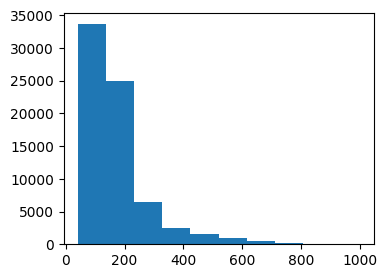

In [19]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(np.clip(freq_predictions, None, 1000), weights=test_df["Exposure"]);

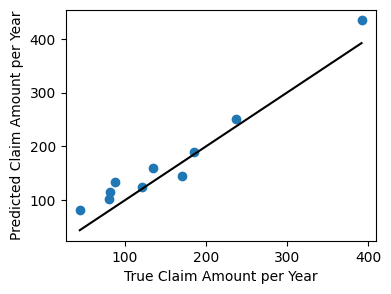

In [20]:
plot_quantiles(test_df["claim_amount_per_year"], freq_predictions, weights=test_df["Exposure"], figsize=(4,3));

### Kombiniertes Modell
Wir trainieren ein Regressionsmodell, das im Falle eines Schadens die Höhe vorhersagt. Diesen Wert können wir mit der Vorhersage des Frequenzmodells multiplizieren.

In [21]:
train_amount = sev_df.merge(train_df[["IDpol", *features]], how="inner", on="IDpol")
valid_amount = sev_df.merge(valid_df[["IDpol", *features]], how="inner", on="IDpol")
train_amount["claim_amount_clipped"] = train_amount["ClaimAmount"].clip(upper=1e4)
valid_amount["claim_amount_clipped"] = valid_amount["ClaimAmount"].clip(upper=1e4)

In [22]:
amount_model = CatBoostRegressor(iterations=200, loss_function="RMSE")
amount_model.fit(
    train_amount[features],
    train_amount["claim_amount_clipped"],
    cat_features=categorical_features,
    eval_set=(valid_amount[features], valid_amount["claim_amount_clipped"]),
    early_stopping_rounds=50,
    verbose=20,
)

Learning rate set to 0.21189
0:	learn: 1736.6373198	test: 1695.2242160	best: 1695.2242160 (0)	total: 3.84ms	remaining: 764ms
20:	learn: 1723.8101811	test: 1693.1594300	best: 1692.5507800 (18)	total: 55.3ms	remaining: 472ms
40:	learn: 1714.3473883	test: 1693.4638988	best: 1692.5507800 (18)	total: 99.4ms	remaining: 386ms
60:	learn: 1705.2538835	test: 1694.9546844	best: 1692.5507800 (18)	total: 148ms	remaining: 337ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1692.55078
bestIteration = 18

Shrink model to first 19 iterations.


Vorhersagen erstellen und kalibrieren.

In [23]:
combined_train_predictions = freq_model.predict(train_plus_df[features]) * amount_model.predict(train_plus_df[features])
combined_factor = (
    np.average(train_plus_df["claim_amount_per_year"], weights=train_plus_df["Exposure"])
    / np.average(combined_train_predictions, weights=train_plus_df["Exposure"])
)
print(combined_factor)
combined_predictions = freq_model.predict(test_df[features]) * amount_model.predict(test_df[features]) * combined_factor
combined_metrics = get_metrics(test_df["claim_amount_per_year"], combined_predictions, weights=test_df["Exposure"])
print(combined_metrics)
evaluations.append({"model_name": "combined_model", **combined_metrics})

1.6389948300053163
{'rmse': 6723.02419255753, 'mae': 304.88728394347487, 'bias': -20.23255642125966, 'aps': 0.09241238644928608}


In [24]:
pd.Series(combined_predictions).describe()

count    133780.000000
mean        188.105331
std         120.229456
min          34.417115
25%         117.563685
50%         149.028416
75%         213.595894
max        1891.696633
dtype: float64

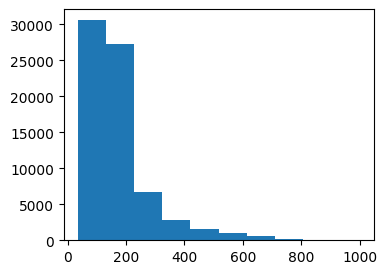

In [25]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(np.clip(combined_predictions, None, 1000), weights=test_df["Exposure"]);

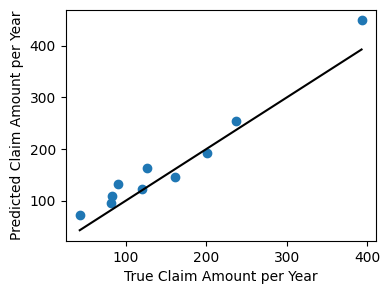

In [26]:
plot_quantiles(test_df["claim_amount_per_year"], combined_predictions, weights=test_df["Exposure"], figsize=(4,3));

## Vergleich

In [27]:
pd.DataFrame(evaluations)

,model_name,rmse,mae,bias,aps
0,global_mean,6723.865836,310.450557,-19.783510,0.048924
1,constant_zero,6725.587737,153.460152,153.460152,0.048924
2,regression_model,6722.952222,303.976035,-20.371276,0.096064
3,freq_model,6723.029622,305.102369,-20.244320,0.094330
4,combined_model,6723.024193,304.887284,-20.232556,0.092412
